# 109511276 練鈞揚
## HW 1 : Part II Bayesian Linear Regression
### Using Python 3.11 version

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# https://blog.csdn.net/deniro_li/article/details/104076555
# https://relguzman.blogspot.com/2018/03/bayesian-linear-regression-explained.html
from pprint import pprint, pformat
from copy import deepcopy


In [192]:
inputData = pd.read_csv("./HW1.csv")

tran_data, test_data = inputData.iloc[:50], inputData.iloc[50:]

# tran_data = tran_data.sort_values('x')
# test_data = test_data.sort_values('x')

x_train, t_train = tran_data['x'], tran_data['t']
x_test, t_test = test_data['x'], test_data['t']

x_predict = np.linspace(0, 3, num=1001)


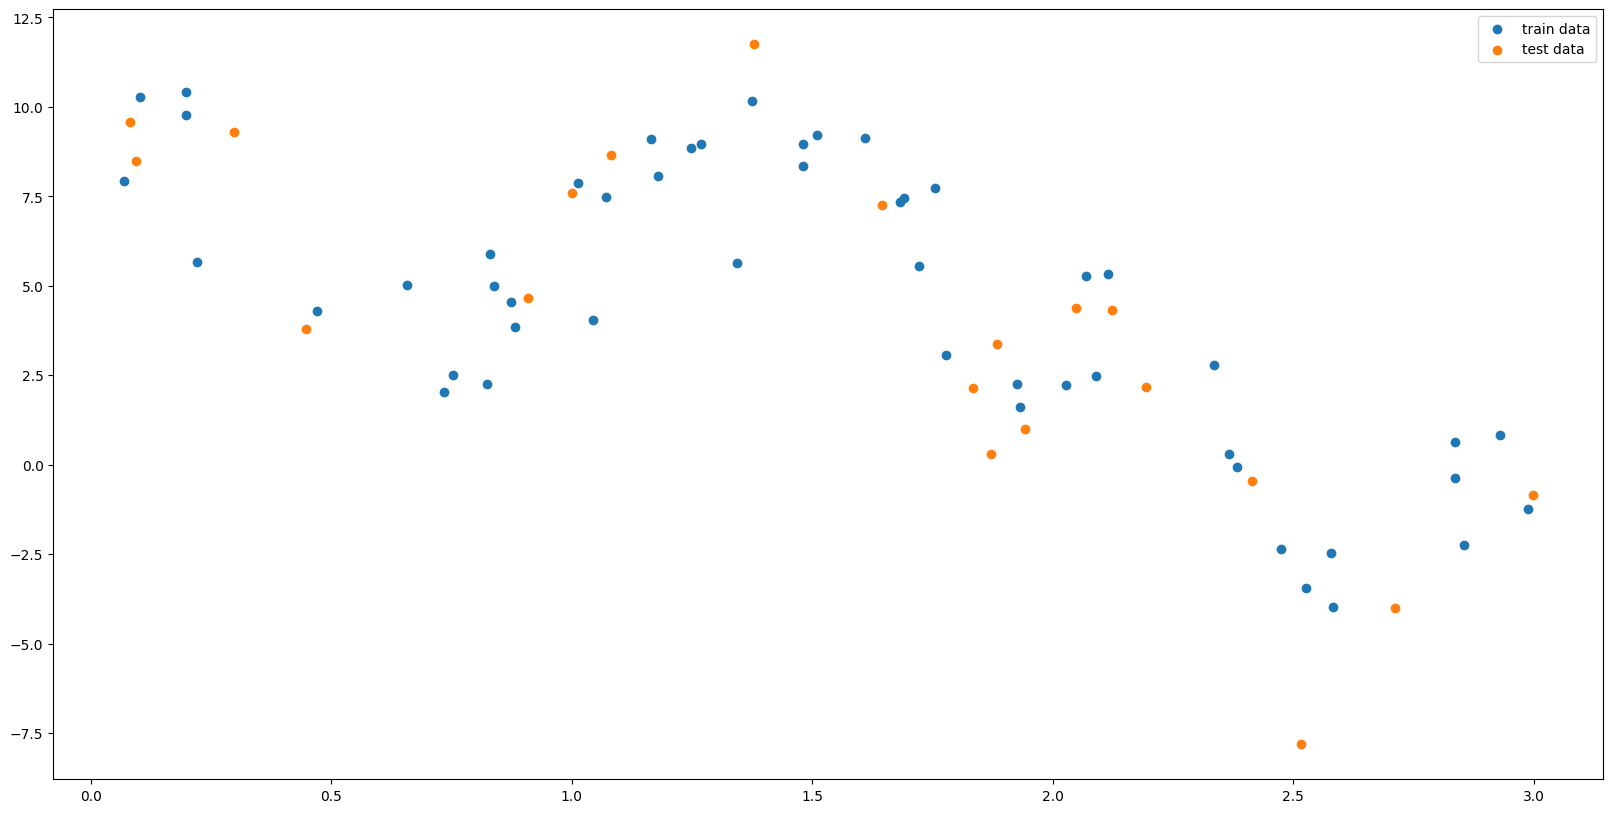

In [193]:
# split data function
plt.figure(figsize=(20, 10))
plt.scatter(x_train, t_train, label="train data")

plt.scatter(x_test, t_test, label="test data")
plt.legend()

plt.show()

### Model 

In [194]:
class BayesianLinearRegression:

    def __init__(self, S, M, beta, m0, sigma_square) -> None:
        self.S = S
        self.M = M
        self.mui_function = lambda x: (3 * x) / M
        self.m0 = m0
        self.beta = beta

        self.s_matrix_0_inv = np.linalg.inv(sigma_square * np.eye(self.M))


        self.design_matrix = None
        self.maximum_likelihood = None
        self.s_matrix_N = None
        self.sigma_function_vector = None

    def __str__(self) -> str:
        design_matrix_str = self.design_matrix.shape if self.design_matrix is not None else None
        maximum_likelihood_str = self.maximum_likelihood.shape if self.maximum_likelihood is not None else None

        return f"S={self.S}, M={self.M}, design_matrix={design_matrix_str}, maximum_likelihood={maximum_likelihood_str}"

    def __repr__(self) -> str:
        return self.__str__()

    @staticmethod
    def logistic_sigmoid(a):
        return 1 / (1 + np.exp(-a))

    def basic_function(self, x, j):
        return self.logistic_sigmoid((x - self.mui_function(j)) / self.S) if j != 0 else np.ones(len(x))

    def make_design_matrix(self, x):

        return np.array(
                [self.basic_function(x, j)
                 for j in range(self.M)]
            ).T

    def find_S_matrix_n(self, design_matrix):

        return np.linalg.inv(self.s_matrix_0_inv + self.beta *
                             (design_matrix.T @ design_matrix))

    def find_maximum_likelihood(self, design_matrix, t):
        self.s_matrix_N = self.find_S_matrix_n(design_matrix=design_matrix)

        res =  self.s_matrix_0_inv @ self.m0 + self.beta * (design_matrix.T @ t)

        return self.s_matrix_N @ res

    def fit(self, x, t):
        self.design_matrix = self.make_design_matrix(x=x)

        self.maximum_likelihood = self.find_maximum_likelihood(design_matrix=self.design_matrix,
                                                               t=t)

        self.sigma_function_vector = self.find_sigma_function(x=x)


    def predict_result(self, x):
        return self.make_design_matrix(x) @ self.maximum_likelihood

    def find_sigma_function(self , x):
        sigma_square_func = lambda x : 1/self.beta + x @ self.s_matrix_N @ x.T

        x_design_matrix = self.make_design_matrix(x)

        return np.sqrt(np.array(
                    [sigma_square_func(line) for line in x_design_matrix]
                ))


### Setting

In [195]:
# using the plt.fill_between for the fill the color
S = 0.1
M = 10
BETA = 1

SIGMA_SQUARE = 1e6

model = BayesianLinearRegression(S=S,
                                 M=M,
                                 beta=BETA ,
                                 m0=np.zeros(M),
                                 sigma_square=SIGMA_SQUARE)

### Train

In [196]:
N = np.arange(1,6)
Nx10 = N * 10

In [197]:
class TrainingTask:
    def __init__(self,model:BayesianLinearRegression,
                 x_train_in ,
                 t_train_in,
                 x_predict_data):

        self.model = model
        self.x_train = x_train_in
        self.t_train = t_train_in
        self.predict_data_linspace = x_predict_data


        self.model.fit(x=self.x_train, t=self.t_train)

        self.predict_result = self.model.predict_result(x=self.predict_data_linspace)

        self.bounding = self.get_bounding(x_data=self.predict_data_linspace,
                                          predict_data=self.predict_result)

    def get_bounding(self, x_data, predict_data):

        sigma_function_vector = self.model.find_sigma_function(x=x_data)
        return predict_data + sigma_function_vector, predict_data - sigma_function_vector

    def get_result(self):
        return self.predict_data_linspace , self.predict_result , self.bounding

    def __str__(self) -> str:
        return f"""Using model {self.model.__str__()}
                x_train size:{self.x_train.shape}
                t_train size:{self.t_train.shape}
                    
                """
    def __repr__(self) -> str:
        return self.__str__()


In [198]:
N_train_set = {n: x_train.iloc[:n] for n in N }
Nx10_train_set = {n: x_train.iloc[:n] for n in Nx10 }

predict_N_train_task = {
    n: TrainingTask(model=deepcopy(model),
                    x_train_in=x_train.iloc[:n],
                    t_train_in=t_train.iloc[:n],
                    x_predict_data=x_predict)
    for n in N
}

predict_Nx10_train_task = {
    n: TrainingTask(model=deepcopy(model),
                    x_train_in=x_train.iloc[:n],
                    t_train_in=t_train.iloc[:n],
                    x_predict_data=x_predict)
    for n in Nx10
}

In [199]:
predict_N_train_task_result = {
    n: task.get_result()
    for n, task in predict_N_train_task.items()
}

predict_Nx10_train_task_result = {
    n: task.get_result()
    for n, task in predict_Nx10_train_task.items()
}

### Plot graph N =[1,2,3,4,5]

<Figure size 640x480 with 0 Axes>

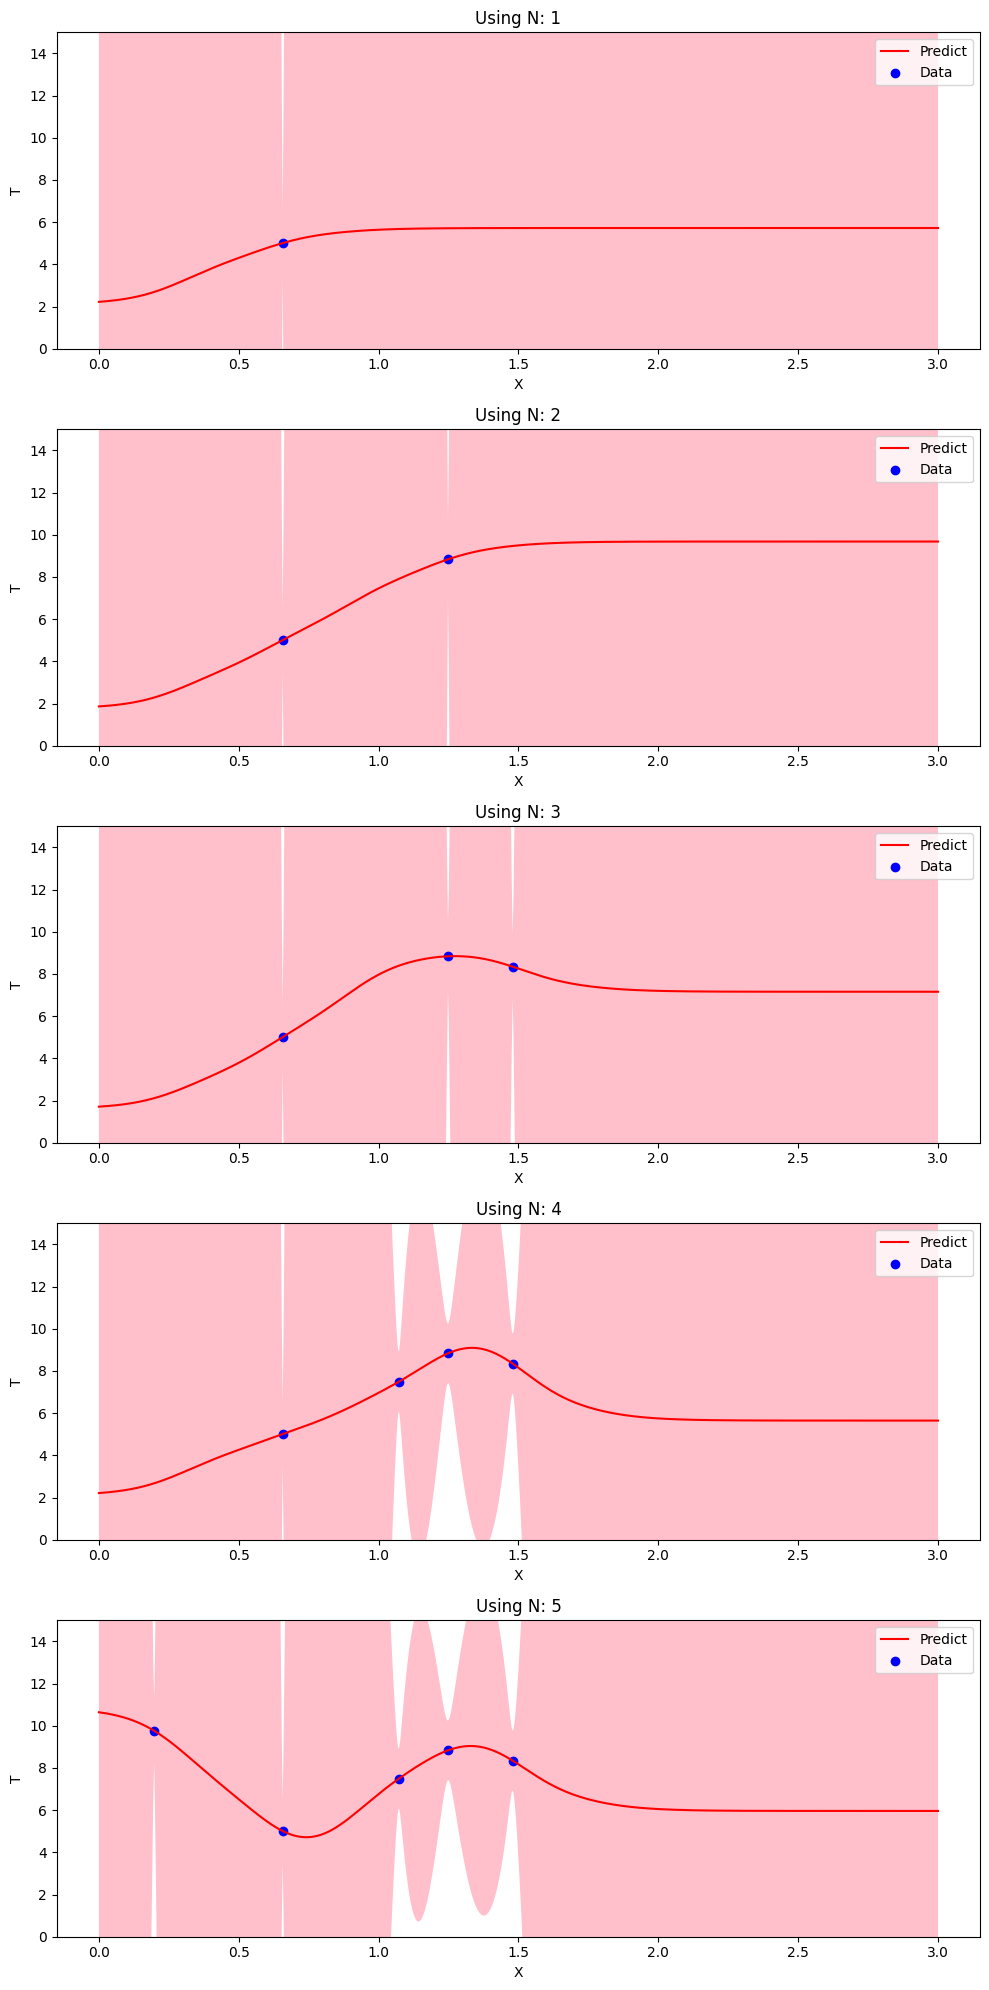

In [202]:
plt.clf()

fig, axis = plt.subplots(5, 1, figsize=(10, 20), tight_layout=True)
for i, (n, result) in enumerate(predict_N_train_task_result.items()):

    predict_x_linspace , predict_result, (upper_bound , lower_bound) = result
    x_display, t_display = x_train.iloc[:n], t_train.iloc[:n]

    axis[i].set_title(f"Using N: {n}")
    axis[i].plot(predict_x_linspace,
                 predict_result,
                 color="red",
                 label="Predict")

    axis[i].fill_between(predict_x_linspace,
                         predict_result,
                         upper_bound,
                         facecolor='pink')

    axis[i].fill_between(predict_x_linspace,
                         predict_result,
                         lower_bound,
                         facecolor='pink')

    axis[i].scatter(x_display,
                    t_display,
                    color='blue',
                    label="Data")

    axis[i].set_xlabel("X")
    axis[i].set_ylabel("T")
    axis[i].set_ylim(0,15)
    # axis[i].autoscale(enable=True, axis='y')

    axis[i].legend()

plt.show()

### Plot graph N =[10,20,30,40,50]

<Figure size 640x480 with 0 Axes>

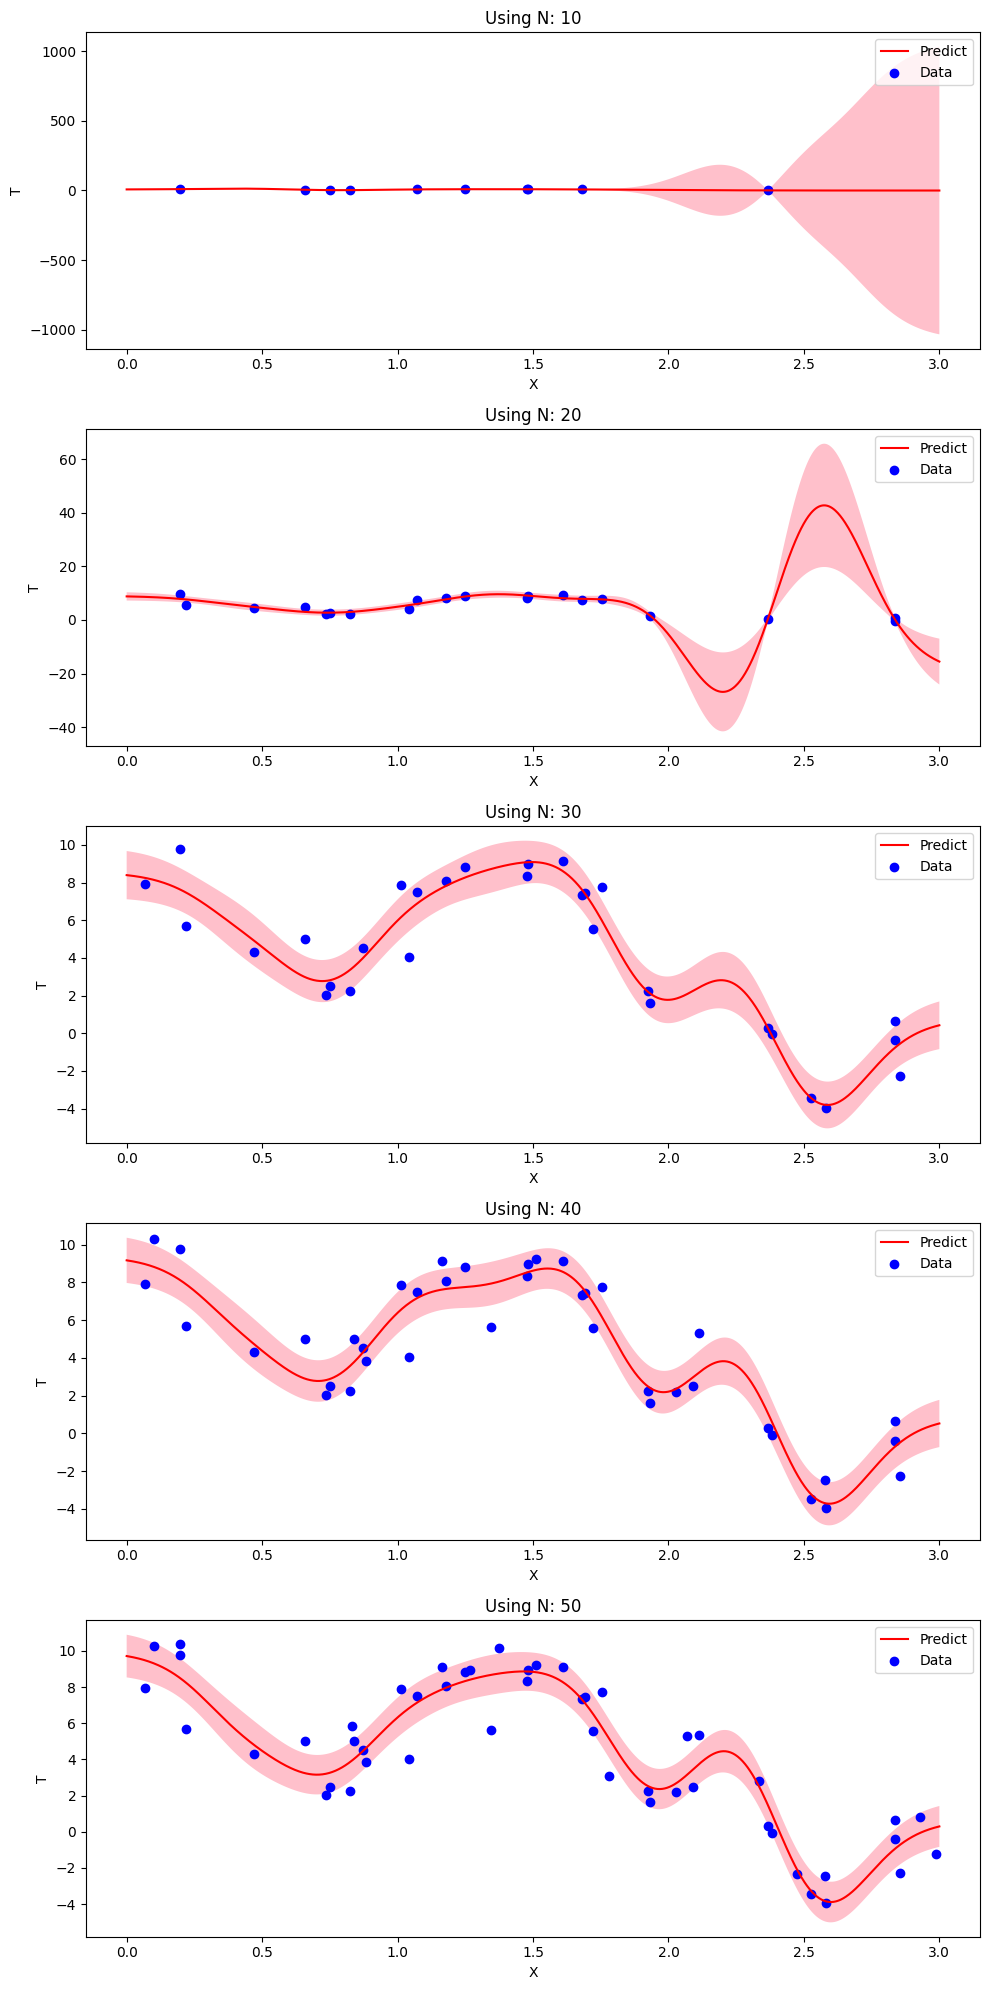

In [201]:
plt.clf()

fig, axis = plt.subplots(5, 1, figsize=(10, 20), tight_layout=True)
for i, (n, result) in enumerate(predict_Nx10_train_task_result.items()):
    predict_x_linspace, predict_result, (upper_bound, lower_bound) = result
    x_display, t_display = x_train.iloc[:n], t_train.iloc[:n]

    axis[i].set_title(f"Using N: {n}")

    axis[i].plot(predict_x_linspace,
                 predict_result,
                 color="red",
                 label="Predict")

    axis[i].fill_between(predict_x_linspace,
                         predict_result,
                         upper_bound,
                         facecolor='pink')

    axis[i].fill_between(predict_x_linspace,
                         predict_result,
                         lower_bound,
                         facecolor='pink')

    axis[i].scatter(x_display, t_display, color='blue', label="Data")
    axis[i].set_xlabel("X")
    axis[i].set_ylabel("T")
    # axis[i].set_ylim(-50, 80)
    axis[i].autoscale(enable=True, axis='y')
    axis[i].legend()

plt.show()